In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import json

In [2]:
data = np.load('lk_and_sig.npy')

In [3]:
print(data[:,-1].min())
print(data[:,-1].max()) # min and max signature in dataset

-38.0
38.0


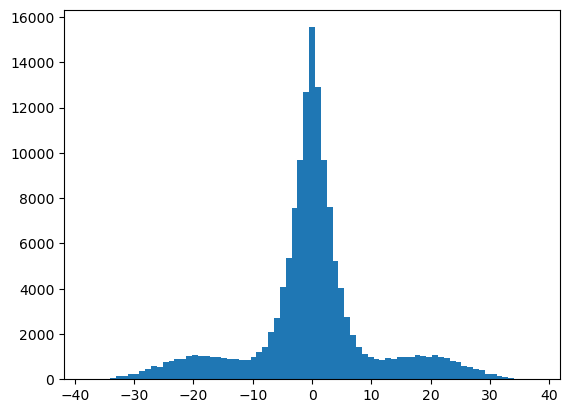

In [4]:
plt.hist(data[:,-1],bins=77)
plt.show()

In [5]:
indexes_to_keep = []
for signature in range(int(data[:,-1].min()), int(data[:,-1].max()+1)) :
    sig_indexes = np.where(data[:,-1]==signature)[0]
    indexes_to_keep.extend(list(np.random.choice(sig_indexes, size=min(1000, len(sig_indexes)), replace=False)))

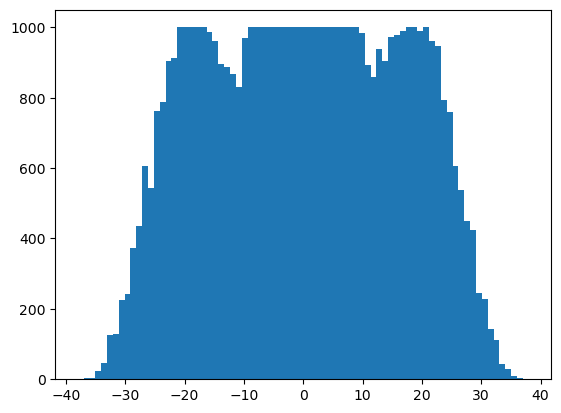

In [6]:
plt.hist(data[indexes_to_keep,-1],bins=77)
plt.show()

In [7]:
with open("braid_words.txt", "r") as f :
    braid_words = json.load(f)
braid_words = [braid_words[i] for i in indexes_to_keep]

In [8]:
data = data[indexes_to_keep]

# Split the data into train and test+validation sets
X_train, X_temp, y_train, y_temp = train_test_split(data[:,:-1], data[:,-1], test_size=0.2, random_state=42)
braid_train, braid_temp, y_train_braid, y_temp_braid = train_test_split(braid_words, data[:,-1], test_size=0.2, random_state=42)

# Split the test+validation set into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
braid_test, braid_val, braid_test_y, braid_val_y = train_test_split(braid_temp, y_temp_braid, test_size=0.5, random_state=42)

In [9]:
# save the targets 
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_val.npy', y_val)

In [10]:
# fit the scaler on the clipped train data
train_clipped = np.clip(X_train, a_min=-100, a_max=100)
scaler1 = StandardScaler()
scaler1.fit(train_clipped)

# transform all datasets
train_normalized = scaler1.transform(train_clipped)
test_normalized = scaler1.transform(np.clip(X_test, a_min=-100, a_max=100))
val_normalized = scaler1.transform(np.clip(X_val, a_min=-100, a_max=100))

# save the datasets 
np.save('clip_then_normalize_train.npy', train_normalized)
np.save('clip_then_normalize_test.npy', test_normalized)
np.save('clip_then_normalize_val.npy', val_normalized)

# save scaler mean and scale
np.save('clip_mean.npy', scaler1.mean_)
np.save('clip_scale.npy', scaler1.scale_)

In [11]:
# different preprocessing approach: abs, +1, then log, then clip, then minmax scale
log_abs_train = np.log1p(np.abs(X_train))
clipped_log_abs_train = np.clip(log_abs_train, a_min=np.zeros(log_abs_train.shape[1]), a_max=np.percentile(log_abs_train, 98, axis=0))
scaler2 = MinMaxScaler()
scaler2.fit(clipped_log_abs_train)

# transform all datasets
train_log_scaled = scaler2.transform(clipped_log_abs_train)
log_abs_test = np.log1p(np.abs(X_test))
clipped_log_abs_test = np.clip(log_abs_test, a_min=np.zeros(log_abs_test.shape[1]), a_max=np.percentile(log_abs_test, 98, axis=0))
test_log_scaled = scaler2.transform(clipped_log_abs_test)
log_abs_val = np.log1p(np.abs(X_val))
clipped_log_abs_val = np.clip(log_abs_val, a_min=np.zeros(log_abs_val.shape[1]), a_max=np.percentile(log_abs_val, 98, axis=0))
val_log_scaled = scaler2.transform(clipped_log_abs_val)

# save the new datasets
np.save('train_log_scaled.npy', train_log_scaled)
np.save('test_log_scaled.npy', test_log_scaled)
np.save('val_log_scaled.npy', val_log_scaled)

# save the train feature max (min is 0)
np.save('clipped_log_train_max.npy', np.percentile(log_abs_train, 98, axis=0))

In [12]:
# save the braids
def save_braids(braids, train_val_or_test) :
    with open(f"{train_val_or_test}_braids.txt", 'w') as f:
        json.dump(braids, f)

save_braids(braid_train, 'train')
save_braids(braid_val, 'val')
save_braids(braid_test, 'test')